In [1]:
%run notebook_setup

# Reproducing the black hole discovery in Thompson et al. 2019

In this science demo tutorial, we will reproduce the results in [Thompson et al. 2019](https://ui.adsabs.harvard.edu/abs/2019Sci...366..637T/abstract), who found and followed-up a candidate stellar-mass black hole companion to a giant star in the Milky Way. We will first use *The Joker* to constrain the orbit of the system using the TRES follow-up radial velocity data released in their paper and show that we get consistent period and companion mass constraints from modeling these data. We will then do a joint analysis of the TRES and APOGEE data for this source by simultaneously fitting for and marginalizing over an unknown constant velocity offset between the two surveys.

A bunch of imports we will need later:

In [2]:
from astropy.io import ascii
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pymc3 as pm
import exoplanet.units as xu
import exoplanet as xo
import corner

import thejoker as tj
from twobody.transforms import get_m2_min

In [3]:
# For reproducibility:
seed = 42
rnd = np.random.RandomState(42)

## Load the data

We will start by loading data, copy-pasted from Table S2 in Thompson et al. 2019):

In [4]:
tres_tbl = ascii.read(
    """8006.97517 0.000 0.075
    8023.98151 -43.313 0.075
    8039.89955 -27.963 0.045
    8051.98423 10.928 0.118
    8070.99556 43.782 0.075
    8099.80651 -30.033 0.054
    8106.91698 -42.872 0.135
    8112.81800 -44.863 0.088
    8123.79627 -25.810 0.115
    8136.59960 15.691 0.146
    8143.78352 34.281 0.087""", 
    names=['HJD', 'rv', 'rv_err'])
tres_tbl['rv'].unit = u.km/u.s
tres_tbl['rv_err'].unit = u.km/u.s

In [5]:
apogee_tbl = ascii.read(
    """6204.95544 -37.417 0.011
    6229.92499 34.846 0.010
    6233.87715 42.567 0.010""", 
    names=['HJD', 'rv', 'rv_err'])
apogee_tbl['rv'].unit = u.km/u.s
apogee_tbl['rv_err'].unit = u.km/u.s

In [6]:
tres_data = tj.RVData(
    t=Time(tres_tbl['HJD'] + 2450000, format='jd', scale='tcb'),
    rv=u.Quantity(tres_tbl['rv']), 
    rv_err=u.Quantity(tres_tbl['rv_err']))

apogee_data = tj.RVData(
    t=Time(apogee_tbl['HJD'] + 2450000, format='jd', scale='tcb'),
    rv=u.Quantity(apogee_tbl['rv']), 
    rv_err=u.Quantity(apogee_tbl['rv_err']))

Let's now plot the data from these two instruments:

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


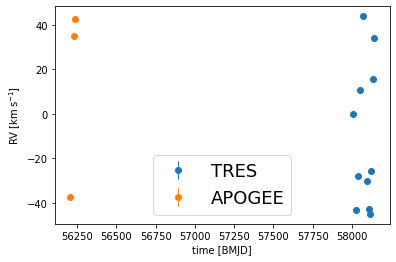

In [7]:
for d, name in zip([tres_data, apogee_data], ['TRES', 'APOGEE']):
    d.plot(color=None, label=name)
plt.legend(fontsize=18)

---

## Run The Joker with just the TRES data

The two data sets are separated by a large gap in observations between the end of APOGEE and the start of the RV follow-up with TRES. Since there are more observations with TRES, we will start by running *The Joker* with just data from TRES before using all of the data. Let's plot the TRES data alone:

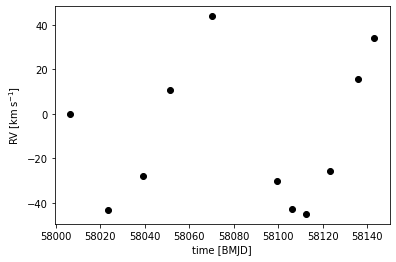

In [8]:
_ = tres_data.plot()

It is pretty clear that there is a periodic signal in the data, with a period between 10s to ~100 days (from eyeballing the plot above), so this limits the range of periods we need to sample over with *The Joker* below. The reported uncertainties on the individual RV measurements (plotted above, I swear) are all very small (typically smaller than the markers). So, we may want to allow for the fact that these could be under-estimated. With *The Joker*, we support this by accepting an additional nonlinear parameter, `s`, that specifies a global, extra uncertainty that is added in quadrature to the data uncertainties while running the sampler. That is, the uncertainties used for computing the likelihood in *The Joker* are computed as:
$$
\sigma_n = \sqrt{\sigma_{n,0}^2 + s^2}
$$
where $\sigma_{n,0}$ are the values reported for each $n$ data point in the tables above. We'll use a log-normal prior on this extra error term, but will otherwise use the default prior form for The Joker:

In [9]:
with pm.Model() as model:
    # Allow extra error to account for under-estimated error bars
    s = xu.with_unit(pm.Lognormal('s', -2, 1),
                     u.km/u.s)
    
    prior = tj.JokerPrior.default(
        P_min=16*u.day, P_max=128*u.day,  # Range of periods to consider
        sigma_K0=30*u.km/u.s, P0=1*u.year,  # scale of the prior on semiamplitude, K
        sigma_v=25*u.km/u.s,  # std dev of the prior on the systemic velocity, v0
        s=s
    )

With the prior set up, we can now generate prior samples, and run the rejection sampling step of *The Joker*:

In [10]:
# Generate a large number of prior samples:
prior_samples = prior.sample(size=1_000_000,
                             random_state=rnd)

In [11]:
# Run rejection sampling with The Joker:
joker = tj.TheJoker(prior, random_state=rnd)
samples = joker.rejection_sample(tres_data, prior_samples,
                                 max_posterior_samples=256)
samples

<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>

Only 1 sample is returned from the rejection sampling step - let's see how well it matches the data:

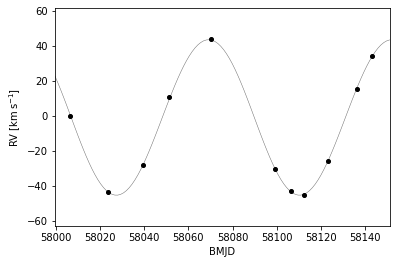

In [12]:
_ = tj.plot_rv_curves(samples, data=tres_data)

Let's look at the values of the sample that was returned, and compare that to the values reported in Thompson et al. 2019, included below for convenience:
$$
P = 83.205 \pm 0.064\\
e = 0.00476 \pm 0.00255\\
K = 44.615 \pm 0.123
$$

In [13]:
samples.tbl['P', 'e', 'K']

P,e,K
d,,km / s
float64,float64,float64
82.82811234957394,0.007054391624082691,-44.374468266292205


Already these look very consistent with the values inferred in the paper! 

Let's now also plot the data phase-folded on the period returned in the one sample we got from *The Joker*:

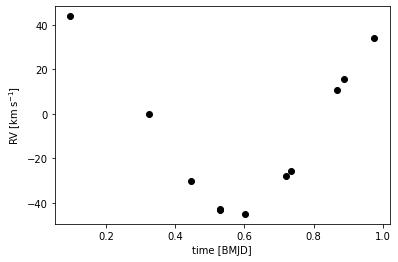

In [14]:
_ = tres_data.plot(phase_fold=samples[0]['P'])

At this point, since the data are very constraining, we could use this one *Joker* sample to initialize standard MCMC to generate posterior samplings in the orbital parameters for this system. We will do that below, but first let's see how things look if we include both TRES *and* APOGEE data in our modeling.

## Run The Joker with TRES+APOGEE data

One of the challenges with incorporating data from the two surveys is that they were taken with two different spectrographs, and there could be instrumental offsets that manifest as shifts in the absolute radial velocities measured between the two instruments. *The Joker* now supports simultaneously sampling over additional parameters that represent instrumental or calibratrion offsets, so let's take a look at how to run *The Joker* in this mode. 

To start, we can pack the two datasets into a single list that contains data from both surveys:

In [15]:
data = [apogee_data, tres_data]

Before we run anything, let's try phase-folding both datasets on the period value we got from running on the TRES data alone:

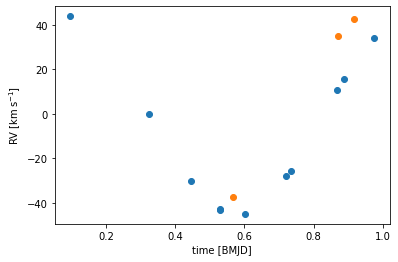

In [16]:
tres_data.plot(color=None, phase_fold=np.mean(samples['P']))
apogee_data.plot(color=None, phase_fold=np.mean(samples['P']))

That looks pretty good, but the period is clearly slightly off and there seems to be a constant velocity offset between the two surveys, given that the APOGEE RV points don't seem to lie in the RV curve. So, let's now try running *The Joker* on the joined dataset!

To allow for an unknown constant velocity offset between TRES and APOGEE, we have to define a new parameter for this offset and specify a prior. We'll put a Gaussian prior on this offset parameter (named `dv0_1` below), with a mean of 0 and a standard deviation of 10 km/s, because it doesn't look like the surveys have a huge offset.

In [17]:
with pm.Model() as model:
    # The parameter that represents the constant velocity offset between
    # APOGEE and TRES:
    dv0_1 = xu.with_unit(pm.Normal('dv0_1', 0, 5.),
                         u.km/u.s)
    
    # The same extra uncertainty parameter as previously defined
    s = xu.with_unit(pm.Lognormal('s', -2, 1),
                     u.km/u.s)
    
    # We can restrict the prior on prior now, using the above
    prior_joint = tj.JokerPrior.default(
        # P_min=16*u.day, P_max=128*u.day,
        P_min=75*u.day, P_max=90*u.day,
        sigma_K0=30*u.km/u.s, P0=1*u.year,
        sigma_v=25*u.km/u.s,
        v0_offsets=[dv0_1],
        s=s
    )
    
prior_samples_joint = prior_joint.sample(size=10_000_000, 
                                         random_state=rnd)

In [18]:
# Run rejection sampling with The Joker:
joker_joint = tj.TheJoker(prior_joint, random_state=rnd)
samples_joint = joker_joint.rejection_sample(data, 
                                             prior_samples_joint,
                                             max_posterior_samples=256)
samples_joint

<JokerSamples [P, e, omega, M0, s, K, v0, dv0_1] (1 samples)>

Here we again only get one sample back from *The Joker*, because these ata are so constraining:

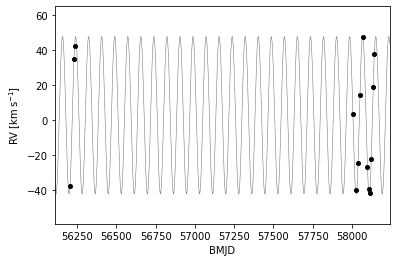

In [19]:
_ = tj.plot_rv_curves(samples_joint, data=data)

Now, let's fire up standard MCMC, using the one *Joker* sample to initialize. We will use the NUTS sampler in `pymc3` to run here. When running MCMC to model radial velocities with Keplerian orbits, it is typically important to think about the parametrization. There are several angle parameters in the two-body problem (e.g., argument of pericenter, phase, inclination, etc.) that can be especially hard to sample over naïvely. Here, for running MCMC, we will instead sample over $M_0 - \omega, \omega$ instead of $M_0, \omega$, and we will define these angles as `exoplanet.distributions.Angle` distributions, which [internally transform and sample in](https://exoplanet.dfm.io/en/stable/user/api/#exoplanet.distributions.Angle) $\cos{x}, \sin{x}$ instead:

In [20]:
from exoplanet.distributions import Angle

with pm.Model():
    
    # See note above: when running MCMC, we will sample in the parameters
    # (M0 - omega, omega) instead of (M0, omega)
    M0_m_omega = xu.with_unit(Angle('M0_m_omega'), u.radian)
    omega = xu.with_unit(Angle('omega'), u.radian)
    # M0 = xu.with_unit(Angle('M0'), u.radian)
    M0 = xu.with_unit(pm.Deterministic('M0', M0_m_omega + omega),
                      u.radian)
    
    # The same offset and extra uncertainty parameters as above:
    dv0_1 = xu.with_unit(pm.Normal('dv0_1', 0, 5.), u.km/u.s)
    s = xu.with_unit(pm.Lognormal('s', -2, 0.5),
                     u.km/u.s)
    
    prior_mcmc = tj.JokerPrior.default(
        P_min=16*u.day, P_max=128*u.day,
        sigma_K0=30*u.km/u.s, P0=1*u.year,
        sigma_v=25*u.km/u.s,
        v0_offsets=[dv0_1],
        s=s,
        pars={'M0': M0, 'omega': omega}
    )
    
    joker_mcmc = tj.TheJoker(prior_mcmc, random_state=rnd)
    mcmc_init = joker_mcmc.setup_mcmc(data, samples_joint)
    
    trace = pm.sample(
        tune=1000, draws=1000,
        start=mcmc_init,
        step=xo.get_dense_nuts_step(target_accept=0.95),
        random_seed=seed)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [v0, K, P, e, s, dv0_1, omega, M0_m_omega]


Sampling 4 chains, 0 divergences:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 1/8000 [00:55<122:42:11, 55.22s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 15/8000 [00:55<85:44:49, 38.66s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 19/8000 [00:55<60:01:18, 27.07s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 23/8000 [00:55<42:01:29, 18.97s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 26/8000 [00:55<29:26:32, 13.29s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 29/8000 [00:56<20:38:12,  9.32s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 32/8000 [00:56<14:28:28,  6.54s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 35/8000 [00:56<10:09:52,  4.59s/draws]

Sampling 4 chains, 0 divergences:   0%|          | 38/8000 [00:56<7:08:48,  3.23s/draws] 

Sampling 4 chains, 0 divergences:   1%|          | 41/8000 [00:56<5:02:04,  2.28s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 44/8000 [00:56<3:33:23,  1.61s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 47/8000 [00:56<2:31:20,  1.14s/draws]

Sampling 4 chains, 0 divergences:   1%|          | 50/8000 [00:57<1:47:52,  1.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 53/8000 [00:57<1:17:29,  1.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 56/8000 [00:57<56:11,  2.36draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 59/8000 [00:57<41:20,  3.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 61/8000 [00:57<30:55,  4.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 64/8000 [00:57<23:37,  5.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 66/8000 [00:57<18:32,  7.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 68/8000 [00:57<14:59,  8.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 71/8000 [00:58<12:26, 10.61draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 73/8000 [00:58<10:50, 12.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 75/8000 [00:58<09:41, 13.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 77/8000 [00:58<08:47, 15.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 80/8000 [00:58<08:06, 16.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 83/8000 [00:58<07:48, 16.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 85/8000 [00:58<07:41, 17.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 87/8000 [00:58<07:28, 17.62draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 107/8000 [00:59<05:25, 24.23draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 115/8000 [00:59<04:53, 26.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 122/8000 [00:59<04:17, 30.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 128/8000 [00:59<03:55, 33.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 134/8000 [00:59<03:43, 35.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 139/8000 [00:59<03:45, 34.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 144/8000 [01:00<03:28, 37.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 149/8000 [01:00<03:31, 37.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 154/8000 [01:00<03:19, 39.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 159/8000 [01:00<03:41, 35.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 163/8000 [01:00<03:36, 36.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 168/8000 [01:00<03:22, 38.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 173/8000 [01:00<03:27, 37.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 177/8000 [01:00<03:27, 37.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 181/8000 [01:01<03:32, 36.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 185/8000 [01:01<03:48, 34.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 189/8000 [01:01<03:46, 34.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 193/8000 [01:01<03:39, 35.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 198/8000 [01:01<03:24, 38.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 203/8000 [01:01<03:28, 37.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 208/8000 [01:01<03:13, 40.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 213/8000 [01:01<03:21, 38.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 218/8000 [01:01<03:15, 39.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 224/8000 [01:02<03:08, 41.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 229/8000 [01:02<03:11, 40.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 234/8000 [01:02<03:31, 36.78draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 238/8000 [01:02<03:28, 37.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 243/8000 [01:02<03:18, 39.04draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 248/8000 [01:02<03:12, 40.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 253/8000 [01:02<03:17, 39.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 258/8000 [01:02<03:15, 39.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 262/8000 [01:03<03:18, 38.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 266/8000 [01:03<03:23, 38.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 271/8000 [01:03<03:16, 39.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 276/8000 [01:03<03:19, 38.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 280/8000 [01:03<03:27, 37.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 285/8000 [01:03<03:18, 38.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 289/8000 [01:03<03:20, 38.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 302/8000 [01:03<02:38, 48.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 310/8000 [01:04<02:23, 53.71draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 318/8000 [01:04<02:14, 57.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 325/8000 [01:04<02:10, 58.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 333/8000 [01:04<02:02, 62.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 340/8000 [01:04<02:05, 60.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 347/8000 [01:04<02:01, 63.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 354/8000 [01:04<02:02, 62.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 361/8000 [01:04<02:02, 62.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 368/8000 [01:04<02:03, 61.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 375/8000 [01:05<02:01, 62.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 382/8000 [01:05<02:00, 63.08draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 389/8000 [01:05<02:24, 52.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 395/8000 [01:05<02:49, 44.81draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 400/8000 [01:05<03:03, 41.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 405/8000 [01:05<02:58, 42.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 411/8000 [01:05<02:50, 44.63draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 417/8000 [01:05<02:41, 47.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 425/8000 [01:06<02:23, 52.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 431/8000 [01:06<02:22, 53.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 437/8000 [01:06<02:30, 50.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 446/8000 [01:06<02:11, 57.58draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 454/8000 [01:06<02:06, 59.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 461/8000 [01:06<02:01, 61.80draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 468/8000 [01:06<02:14, 56.12draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 474/8000 [01:06<02:25, 51.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 480/8000 [01:07<02:24, 52.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 486/8000 [01:07<02:32, 49.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 492/8000 [01:07<02:42, 46.07draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 497/8000 [01:07<02:46, 45.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 504/8000 [01:07<02:28, 50.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 510/8000 [01:07<02:30, 49.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 516/8000 [01:07<02:54, 42.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 521/8000 [01:08<02:55, 42.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 527/8000 [01:08<02:41, 46.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 534/8000 [01:08<02:31, 49.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 540/8000 [01:08<02:48, 44.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 545/8000 [01:08<02:49, 44.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 550/8000 [01:08<03:27, 35.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 555/8000 [01:08<03:25, 36.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 561/8000 [01:08<03:18, 37.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 568/8000 [01:09<02:52, 43.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 573/8000 [01:09<03:15, 38.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 578/8000 [01:09<03:16, 37.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 583/8000 [01:09<04:04, 30.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 588/8000 [01:09<03:42, 33.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 592/8000 [01:09<03:31, 34.99draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 597/8000 [01:09<03:14, 38.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 602/8000 [01:10<03:01, 40.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 610/8000 [01:10<02:36, 47.33draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 617/8000 [01:10<02:21, 52.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 625/8000 [01:10<02:08, 57.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 635/8000 [01:10<01:52, 65.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 651/8000 [01:10<01:32, 79.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 663/8000 [01:10<01:23, 87.95draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 674/8000 [01:10<01:21, 89.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 689/8000 [01:10<01:12, 101.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 702/8000 [01:11<01:08, 106.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 717/8000 [01:11<01:03, 114.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 733/8000 [01:11<00:58, 124.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 753/8000 [01:11<00:51, 139.82draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 772/8000 [01:11<00:48, 148.54draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 788/8000 [01:11<00:47, 150.43draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 804/8000 [01:11<00:49, 145.78draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 820/8000 [01:11<00:52, 137.62draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 835/8000 [01:11<00:52, 135.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 849/8000 [01:12<00:53, 133.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 863/8000 [01:12<00:53, 134.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 880/8000 [01:12<00:49, 142.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 895/8000 [01:12<00:51, 137.29draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 914/8000 [01:12<00:48, 146.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 929/8000 [01:12<00:53, 132.35draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 943/8000 [01:12<00:54, 128.36draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 958/8000 [01:12<00:53, 131.95draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 974/8000 [01:12<00:50, 138.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 991/8000 [01:13<00:47, 146.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1006/8000 [01:13<00:51, 136.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1020/8000 [01:13<01:05, 107.09draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1032/8000 [01:13<01:05, 106.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1050/8000 [01:13<00:57, 120.29draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1065/8000 [01:13<00:55, 124.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 1079/8000 [01:13<00:54, 127.96draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 1093/8000 [01:13<00:54, 127.47draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1107/8000 [01:13<00:54, 125.59draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1122/8000 [01:14<00:53, 127.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1136/8000 [01:14<01:07, 102.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 1148/8000 [01:14<01:09, 98.08draws/s] 

Sampling 4 chains, 0 divergences:  15%|█▍        | 1161/8000 [01:14<01:05, 104.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 1174/8000 [01:14<01:01, 110.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 1189/8000 [01:14<00:57, 118.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 1202/8000 [01:14<00:57, 118.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 1215/8000 [01:14<00:57, 117.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 1228/8000 [01:15<01:00, 111.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1242/8000 [01:15<00:57, 116.74draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1257/8000 [01:15<00:54, 123.97draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1270/8000 [01:15<01:00, 111.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1282/8000 [01:15<01:01, 109.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 1295/8000 [01:15<00:58, 114.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 1307/8000 [01:15<00:57, 115.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 1319/8000 [01:15<00:57, 115.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1338/8000 [01:15<00:51, 130.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1357/8000 [01:16<00:46, 143.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1376/8000 [01:16<00:43, 152.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 1393/8000 [01:16<00:44, 149.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1414/8000 [01:16<00:40, 161.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1435/8000 [01:16<00:38, 171.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 1462/8000 [01:16<00:34, 188.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 1484/8000 [01:16<00:33, 196.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 1508/8000 [01:16<00:31, 205.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 1538/8000 [01:16<00:28, 226.70draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 1562/8000 [01:17<00:28, 228.56draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 1586/8000 [01:17<00:28, 224.83draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 1610/8000 [01:17<00:31, 204.93draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 1632/8000 [01:17<00:30, 207.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 1660/8000 [01:17<00:28, 221.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 1687/8000 [01:17<00:27, 232.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 1715/8000 [01:17<00:25, 244.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1741/8000 [01:17<00:25, 243.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 1769/8000 [01:17<00:24, 251.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1802/8000 [01:18<00:22, 270.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1834/8000 [01:18<00:21, 282.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 1869/8000 [01:18<00:20, 296.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 1900/8000 [01:18<00:20, 296.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 1937/8000 [01:18<00:19, 315.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 1972/8000 [01:18<00:18, 324.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 2010/8000 [01:18<00:17, 337.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 2048/8000 [01:18<00:17, 349.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 2085/8000 [01:18<00:16, 354.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 2123/8000 [01:18<00:16, 359.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 2161/8000 [01:19<00:16, 358.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2203/8000 [01:19<00:15, 374.18draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2241/8000 [01:19<00:16, 345.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 2277/8000 [01:19<00:16, 344.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 2312/8000 [01:19<00:17, 334.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 2346/8000 [01:19<00:17, 324.08draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 2379/8000 [01:19<00:19, 294.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 2411/8000 [01:19<00:18, 301.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 2444/8000 [01:19<00:18, 308.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 2476/8000 [01:20<00:20, 276.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 2506/8000 [01:20<00:19, 280.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2541/8000 [01:20<00:18, 296.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 2582/8000 [01:20<00:16, 322.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2616/8000 [01:20<00:18, 288.09draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2647/8000 [01:20<00:19, 271.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 2678/8000 [01:20<00:19, 278.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 2707/8000 [01:20<00:18, 278.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 2736/8000 [01:20<00:18, 277.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 2768/8000 [01:21<00:18, 289.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 2802/8000 [01:21<00:17, 302.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 2834/8000 [01:21<00:16, 306.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 2869/8000 [01:21<00:16, 315.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 2910/8000 [01:21<00:15, 338.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 2952/8000 [01:21<00:14, 354.81draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3000/8000 [01:21<00:13, 382.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 3042/8000 [01:21<00:12, 390.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 3082/8000 [01:21<00:12, 391.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 3122/8000 [01:22<00:12, 376.93draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 3161/8000 [01:22<00:13, 366.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 3199/8000 [01:22<00:14, 330.51draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 3234/8000 [01:22<00:15, 298.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 3266/8000 [01:22<00:15, 300.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 3304/8000 [01:22<00:14, 320.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3339/8000 [01:22<00:14, 328.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 3377/8000 [01:22<00:13, 341.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 3425/8000 [01:22<00:12, 373.67draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 3483/8000 [01:23<00:10, 416.48draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 3528/8000 [01:23<00:10, 416.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 3572/8000 [01:23<00:27, 160.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 3607/8000 [01:23<00:23, 190.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 3648/8000 [01:23<00:19, 225.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 3691/8000 [01:24<00:16, 262.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3729/8000 [01:24<00:15, 281.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 3766/8000 [01:24<00:14, 298.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3802/8000 [01:24<00:13, 308.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3838/8000 [01:24<00:12, 320.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 3880/8000 [01:24<00:12, 343.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 3917/8000 [01:24<00:11, 345.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 3958/8000 [01:24<00:11, 362.75draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 4000/8000 [01:24<00:10, 375.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 4040/8000 [01:25<00:10, 380.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 4081/8000 [01:25<00:10, 388.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4122/8000 [01:25<00:09, 394.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 4163/8000 [01:25<00:09, 395.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4206/8000 [01:25<00:09, 403.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 4247/8000 [01:25<00:09, 391.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 4291/8000 [01:25<00:09, 404.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 4332/8000 [01:25<00:09, 396.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 4377/8000 [01:25<00:08, 411.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 4425/8000 [01:25<00:08, 428.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 4474/8000 [01:26<00:07, 443.14draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4525/8000 [01:26<00:07, 460.31draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 4572/8000 [01:26<00:07, 432.28draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4616/8000 [01:26<00:07, 429.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 4660/8000 [01:26<00:07, 419.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 4707/8000 [01:26<00:07, 429.78draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 4756/8000 [01:26<00:07, 444.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 4802/8000 [01:26<00:07, 447.86draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 4861/8000 [01:26<00:06, 482.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 4911/8000 [01:27<00:06, 485.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 4961/8000 [01:27<00:06, 467.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5009/8000 [01:27<00:06, 459.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 5056/8000 [01:27<00:06, 459.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 5107/8000 [01:27<00:06, 471.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 5155/8000 [01:27<00:06, 472.09draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 5208/8000 [01:27<00:05, 483.15draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 5257/8000 [01:27<00:05, 474.96draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 5305/8000 [01:27<00:05, 461.89draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 5352/8000 [01:27<00:05, 459.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5407/8000 [01:28<00:05, 479.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 5456/8000 [01:28<00:05, 480.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 5505/8000 [01:28<00:05, 475.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 5553/8000 [01:28<00:05, 461.78draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 5600/8000 [01:28<00:12, 192.46draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 5635/8000 [01:29<00:10, 219.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 5670/8000 [01:29<00:10, 221.88draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 5701/8000 [01:29<00:10, 227.96draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5730/8000 [01:29<00:09, 227.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5758/8000 [01:29<00:09, 239.11draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 5786/8000 [01:29<00:09, 245.57draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5817/8000 [01:29<00:08, 261.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5845/8000 [01:29<00:08, 265.16draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 5873/8000 [01:30<00:08, 254.95draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 5900/8000 [01:30<00:08, 251.03draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 5926/8000 [01:30<00:08, 249.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 5955/8000 [01:30<00:07, 259.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 5982/8000 [01:30<00:07, 254.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 6008/8000 [01:30<00:07, 251.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 6044/8000 [01:30<00:07, 274.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 6079/8000 [01:30<00:06, 292.56draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6122/8000 [01:30<00:05, 321.37draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 6164/8000 [01:30<00:05, 343.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6200/8000 [01:31<00:05, 344.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6236/8000 [01:31<00:05, 328.31draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 6270/8000 [01:31<00:05, 331.21draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 6317/8000 [01:31<00:04, 362.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 6357/8000 [01:31<00:04, 370.59draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 6396/8000 [01:31<00:04, 374.94draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 6438/8000 [01:31<00:04, 385.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 6486/8000 [01:31<00:03, 405.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6528/8000 [01:31<00:03, 405.04draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 6569/8000 [01:32<00:09, 144.74draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▎ | 6600/8000 [01:32<00:08, 158.90draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6628/8000 [01:32<00:08, 165.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6653/8000 [01:33<00:07, 171.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 6676/8000 [01:33<00:07, 174.58draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 6698/8000 [01:33<00:07, 176.96draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 6719/8000 [01:33<00:07, 182.58draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 6742/8000 [01:33<00:06, 193.95draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 6764/8000 [01:33<00:06, 196.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 6792/8000 [01:33<00:05, 213.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 6816/8000 [01:33<00:05, 217.78draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 6843/8000 [01:33<00:05, 229.78draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 6869/8000 [01:34<00:04, 237.82draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 6894/8000 [01:34<00:04, 235.41draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 6919/8000 [01:34<00:04, 236.00draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6943/8000 [01:34<00:04, 226.34draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6966/8000 [01:34<00:04, 224.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 6990/8000 [01:34<00:04, 228.23draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7013/8000 [01:34<00:04, 223.35draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7039/8000 [01:34<00:04, 232.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 7066/8000 [01:34<00:03, 241.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 7092/8000 [01:34<00:03, 244.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 7117/8000 [01:35<00:03, 237.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 7141/8000 [01:35<00:03, 228.80draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 7165/8000 [01:35<00:03, 224.94draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 7188/8000 [01:35<00:03, 221.75draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 7211/8000 [01:35<00:03, 213.96draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 7239/8000 [01:35<00:03, 228.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 7263/8000 [01:35<00:03, 225.27draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 7286/8000 [01:35<00:03, 218.08draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 7309/8000 [01:35<00:03, 220.23draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7332/8000 [01:36<00:03, 216.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7354/8000 [01:36<00:03, 206.28draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7375/8000 [01:36<00:03, 202.90draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 7396/8000 [01:36<00:03, 198.30draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7418/8000 [01:36<00:02, 203.21draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7441/8000 [01:36<00:02, 210.48draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 7464/8000 [01:36<00:02, 214.59draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 7487/8000 [01:36<00:02, 218.45draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 7511/8000 [01:36<00:02, 223.26draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 7540/8000 [01:37<00:01, 239.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 7565/8000 [01:37<00:01, 235.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 7589/8000 [01:37<00:01, 228.27draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 7613/8000 [01:37<00:01, 225.57draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 7637/8000 [01:37<00:01, 229.51draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 7663/8000 [01:37<00:01, 235.27draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 7689/8000 [01:37<00:01, 239.25draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 7714/8000 [01:37<00:01, 225.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7737/8000 [01:37<00:01, 215.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7760/8000 [01:38<00:01, 217.03draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 7783/8000 [01:38<00:00, 218.97draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7806/8000 [01:38<00:00, 221.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7830/8000 [01:38<00:00, 226.54draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7853/8000 [01:38<00:00, 225.03draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 7876/8000 [01:38<00:00, 221.63draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 7899/8000 [01:38<00:00, 209.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7921/8000 [01:38<00:00, 209.77draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 7943/8000 [01:38<00:00, 211.54draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7966/8000 [01:38<00:00, 216.53draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 7988/8000 [01:39<00:00, 211.98draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [01:39<00:00, 80.32draws/s] 

We can now use `pymc3` to look at some statistics of the MC chains to assess convergence:

In [21]:
pm.summary(trace, var_names=prior_mcmc.par_names)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,83.160,0.014,83.133,83.185,0.000,0.000,1356.0,1356.0,1353.0,1983.0,1.0
e,0.003,0.002,0.000,0.007,0.000,0.000,1325.0,1325.0,1050.0,1027.0,1.0
omega,0.509,1.032,-1.231,3.124,0.025,0.028,1713.0,667.0,1895.0,1064.0,1.0
M0,0.008,1.034,-1.731,2.622,0.025,0.029,1699.0,637.0,1895.0,1011.0,1.0
s,0.219,0.055,0.129,0.322,0.001,0.001,1785.0,1785.0,1829.0,2308.0,1.0
K,-44.720,0.102,-44.908,-44.529,0.002,0.002,1998.0,1998.0,2017.0,2045.0,1.0
v0,2.178,0.573,1.182,3.346,0.015,0.011,1382.0,1382.0,1374.0,2133.0,1.0
dv0_1,-2.632,0.590,-3.775,-1.538,0.016,0.011,1355.0,1355.0,1341.0,2047.0,1.0


We can then transform the MCMC samples back into a `JokerSamples` instance so we can manipulate and visualize the samples:

In [22]:
mcmc_samples = joker_mcmc.trace_to_samples(trace, data=data)
mcmc_samples.wrap_K()

<JokerSamples [P, e, omega, M0, s, K, v0, dv0_1] (4000 samples)>

For example, we can make a [corner](https://corner.readthedocs.io/en/latest/) plot of the orbital parameters (note the strong degenceracy between `M0` and `omega`! But also note that we don't sample in these parameters explicitly, so this shouldn't affect convergence):

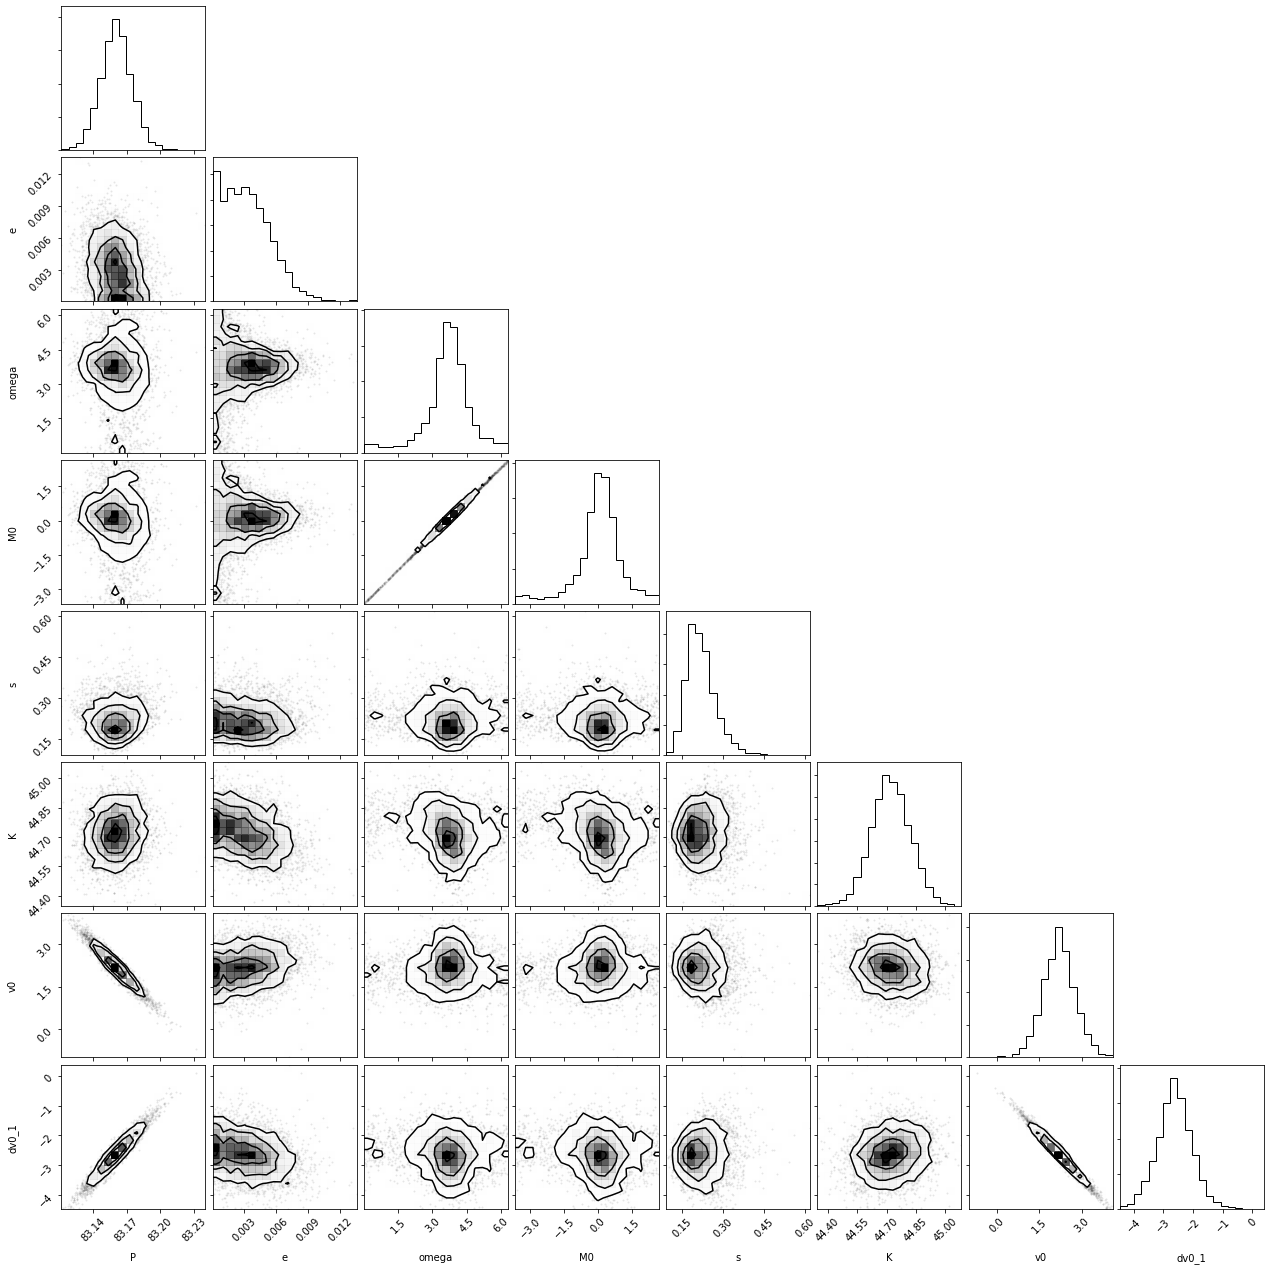

In [23]:
df = mcmc_samples.tbl.to_pandas()
_ = corner.corner(df)

We can also use the median MCMC sample to fold the data and plot residuals relative to our inferred RV model:

(-1.0, 1.0)

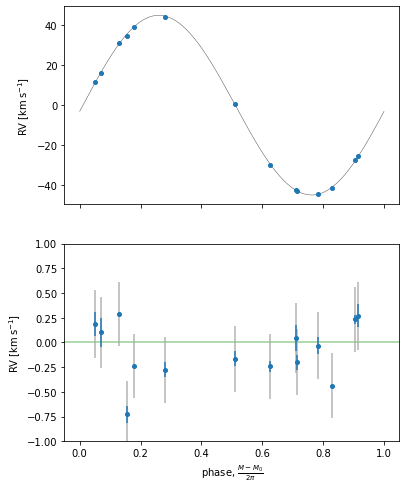

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

_ = tj.plot_phase_fold(mcmc_samples.median(), data, ax=axes[0], add_labels=False)
_ = tj.plot_phase_fold(mcmc_samples.median(), data, ax=axes[1], residual=True)

for ax in axes:
    ax.set_ylabel(f'RV [{apogee_data.rv.unit:latex_inline}]')
    
axes[1].axhline(0, zorder=-10, color='tab:green', alpha=0.5)
axes[1].set_ylim(-1, 1)

Finally, let's convert our orbit samples into binary mass function, $f(M)$, values to compare with one of the main conclusions of the Thompson et al. paper. We can do this by first converting the samples to `KeplerOrbit` objects, and then using the `.m_f` attribute to get the binary mass function values:

In [ ]:
mfs = u.Quantity([mcmc_samples.get_orbit(i).m_f
                  for i in np.random.choice(len(mcmc_samples), 1024)])
plt.hist(mfs.to_value(u.Msun), bins=32);
plt.xlabel(rf'$f(M)$ [{u.Msun:latex_inline}]');

# Values from Thompson et al., showing 1-sigma region
plt.axvline(0.766, zorder=100, color='tab:orange')
plt.axvspan(0.766 - 0.00637,
            0.766 + 0.00637,
            zorder=10, color='tab:orange', 
            alpha=0.4, lw=0)

In the end, using both the APOGEE and TRES data, we confirm the results from the paper, and find that the binary mass function value suggests a large mass companion. A success for reproducible science!